# Day2宿題 - 鈴木雅彦

## ライブラリとファイルの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import log_loss # 分類問題における性能評価に関する関数
from sklearn.metrics import accuracy_score # 〃
from sklearn.metrics import precision_score # 〃
from sklearn.metrics import recall_score # 〃
from sklearn.metrics import confusion_matrix # 〃

In [2]:
df = pd.read_csv(
    './data/ks-projects-201612.csv',
    encoding = "Windows-1252"
)

/Users/suzukimasahiko/anaconda3/envs/skillupai-ml-tokyo8-20181023/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 汎化性能の確認

In [3]:
# 実験用のデータを用意する
df2 = df[df['state '].isin(['successful', 'failed'])]
df2 = df2.head(1000)
df2['state'] = df2['state '] == 'successful'
df2 = df2.rename(columns={'goal ': 'goal', 'backers ': 'backers'})
df2 = df2[['state', 'goal', 'backers']]# pledgedを使ったら正解率1.0になってしまうので封印
df2 = df2.astype({'goal': float, 'backers': float})
display(df2.shape)
display(df2.dtypes)
display(df2.head())

# SGDClassifierに渡しやすい形にしておく
X = df2.drop(columns='state')
y = df2['state']

(1000, 3)

state         bool
goal       float64
backers    float64
dtype: object

,state,goal,backers
0,False,1000.0,0.0
1,False,45000.0,3.0
2,False,5000.0,1.0
4,True,50000.0,224.0
5,True,1000.0,16.0


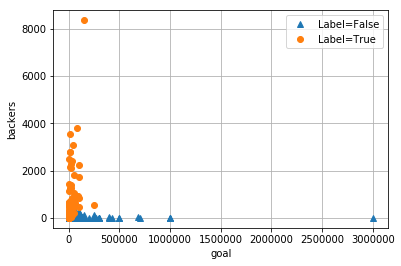

In [4]:
# グラフを描写して線形分離できそうか確認する(この後も何度か使うので関数化しておこう)
def myplot(X, y):
  d0 = X[y == False]
  d1 = X[y == True]

  plt.grid(True)
  plt.xlabel('goal')
  plt.ylabel('backers')
  plt.plot(d0['goal'], d0['backers'], '^', color='C0', label='Label=False')
  plt.plot(d1['goal'], d1['backers'], 'o', color='C1', label='Label=True')
  plt.legend(loc='best')

myplot(X, y)

### まずはそのままロジスティック回帰

In [5]:
# scikit-learnのSGDClassifierを使う
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)

# 学習
clf.fit(X, y)

print('重み')
display(clf.intercept_[0])
display(clf.coef_[0])

# 予測
y_est = clf.predict(X)

# 結果の確認(この後も何度か使うので関数化しておこう)
def check_result(y, y_est):

  print('対数尤度')
  display(-log_loss(y, y_est))

  print('正答率')
  print('Accuracy:\t{:.2%}'.format(accuracy_score(y, y_est)))
  print('Precision:\t{:.2%}'.format(precision_score(y, y_est)))
  print('Recall:\t{:.2%}\n'.format(recall_score(y, y_est)))

  print('予測値と正解のクロス集計表')
  conf_mat = pd.DataFrame(confusion_matrix(y, y_est),
                        index=['正解 = 0', '正解 = 1'],
                        columns=['予測値 = 0', '予測値 = 1'])
  display(conf_mat)

check_result(y, y_est)

重み


188.20765047511517

array([  -5476.34049457, 1417982.05246558])

対数尤度


-4.110199947919403

正答率
Accuracy:	88.10%
Precision:	79.22%
Recall:	97.14%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,473,107
正解 = 1,12,408


### ホールドアウト法

In [6]:
# 学習用データとテストデータを分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

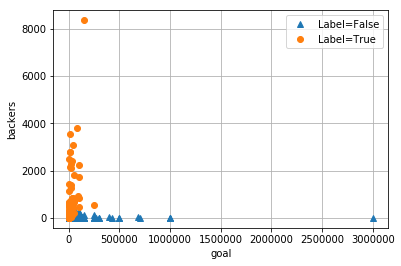

In [7]:
# 学習用データの分布
myplot(X_train, y_train)

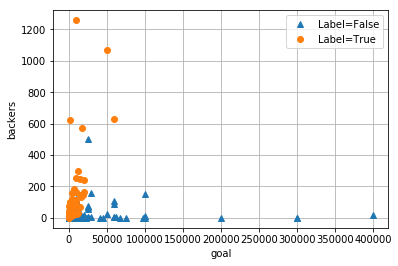

In [8]:
# テスト用データの分布
myplot(X_test, y_test)

In [9]:
# scikit-learnのSGDClassifierで学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)

print('重み')
display(clf.intercept_[0])
display(clf.coef_[0])

重み


1210.0697368461842

array([  -6182.13507637, 1658792.82697299])

In [10]:
# 訓練誤差
y_train_est = clf.predict(X_train)
check_result(y_train, y_train_est)

対数尤度


-3.842518833676834

正答率
Accuracy:	88.88%
Precision:	80.77%
Recall:	97.39%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,375,80
正解 = 1,9,336


In [11]:
# 汎化誤差
y_test_est = clf.predict(X_test)
check_result(y_test, y_test_est)

対数尤度


-5.6990180447747925

正答率
Accuracy:	83.50%
Precision:	70.59%
Recall:	96.00%

予測値と正解のクロス集計表


,予測値 = 0,予測値 = 1
正解 = 0,95,30
正解 = 1,3,72


### 交差検証(クロスバリデーション)法

Python: pandas の DataFrame を scikit-learn で KFold するときの注意点
https://blog.amedama.jp/entry/2018/06/21/235951

In [12]:
# 汎化誤差
scores = pd.DataFrame()

# テスト役を交代させながら学習と評価を繰り返す
kf = KFold(n_splits=5, random_state=1234)
for train_index, test_index in kf.split(X):
    
    # KFoldより与えられたindexを使ってDataFrameからデータを取り出す
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    # scikit-learnのSGDClassifierで学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000,
                        fit_intercept=True, random_state=1234)
    clf.fit(X_train, y_train)

    # 汎化誤差を記録する
    y_est = clf.predict(X_test)
    scores = scores.append({
        '1.対数尤度(LogisticLoss)': -log_loss(y_test, y_est),
        '2.正確度(Accuracy)': accuracy_score(y_test, y_est),
        '3.適合度(Precision)': precision_score(y_test, y_est),
        '4.再現度(Recall)': recall_score(y_test, y_est)
    }, ignore_index=True)

# 結果をまとめて確認する。全体の性能は平均値(mean)を見る
display(scores)
display(scores.describe())

,1.対数尤度(LogisticLoss),2.正確度(Accuracy),3.適合度(Precision),4.再現度(Recall)
0,-3.108554,0.910,0.846154,0.977778
1,-4.835517,0.860,0.782178,0.929412
2,-3.626651,0.895,0.811321,0.988506
3,-3.972043,0.885,0.798077,0.976471
4,-5.180932,0.850,0.712871,0.986301


,1.対数尤度(LogisticLoss),2.正確度(Accuracy),3.適合度(Precision),4.再現度(Recall)
count,5.000000,5.000000,5.000000,5.000000
mean,-4.144740,0.880000,0.790120,0.971693
std,0.854808,0.024749,0.049201,0.024206
min,-5.180932,0.850000,0.712871,0.929412
25%,-4.835517,0.860000,0.782178,0.976471
50%,-3.972043,0.885000,0.798077,0.977778
75%,-3.626651,0.895000,0.811321,0.986301
max,-3.108554,0.910000,0.846154,0.988506


## 欠損値と異常値への対応

In [24]:
# 実験用のデータを用意する
df3 = df[df['state '].isin(['successful', 'failed'])]
df3 = df3.head(3100)
df3 = df3.rename(columns={
    'ID ': 'id', 'name ': 'name', 'category ': 'category', 'main_category ': 'main_category', 'currency ': 'currency',
    'deadline ': 'deadline', 'goal ': 'goal', 'launched ': 'launched', 'pledged ': 'pledged', 'state ': 'state',
    'backers ': 'backers', 'country ': 'country', 'usd pledged ': 'usd_pledged'})
df3['state'] = df3['state'] == 'successful'
df3 = df3.astype({'goal': float, 'pledged': float, 'backers': float, 'usd_pledged': float})

In [25]:
# 欠損値の確認
display(df3.isnull().sum())

id                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd_pledged         1
Unnamed: 13      3100
Unnamed: 14      3100
Unnamed: 15      3100
Unnamed: 16      3100
dtype: int64

In [26]:
# 元のファイルの記述に問題がある
display(df3[df3['usd_pledged'].isnull()])
# この行は捨てる
df3 = df3[~df3['usd_pledged'].isnull()]

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
2102,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26 19:46:26,5000.0,2016-04-26 19:46:26,5170.0,True,0.0,"N,""0",NaN,NaN,NaN,NaN,NaN


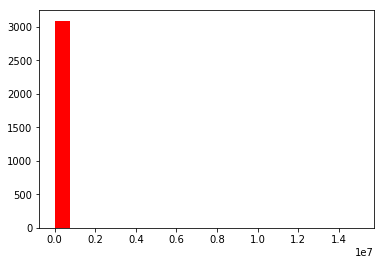

In [67]:
# goalをヒストグラムで確認
plt.hist(df3['goal'], bins=20, color='r')
plt.show()

In [71]:
# goalが極端に大きい値を実データを目視確認
df3.sort_values('goal', ascending=False).head()
# 特におかしなデータではなさそうだけど、正規化して使った方がいいんだろうなー

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
2708,1016210580,INDIRA – THE FIRST INDIAN GRAND MUSICAL,Musical,Theater,EUR,2016-04-27 13:08:01,15000000.0,2016-02-27 13:08:01,15.0,False,6.0,ES,16.593655,NaN,NaN,NaN,NaN
2577,1015466274,Genesis,Film & Video,Film & Video,EUR,2015-09-01 23:55:00,5000000.0,2015-07-07 21:14:52,0.0,False,0.0,IT,0.000000,NaN,NaN,NaN,NaN
1540,1009207145,** GOLIATH **,Product Design,Design,CAD,2014-07-21 21:46:00,3850000.0,2014-06-21 22:34:21,285.0,False,5.0,CA,263.405003,NaN,NaN,NaN,NaN
895,1005237669,The Old Soul of a Lion,Film & Video,Film & Video,USD,2014-10-14 20:16:22,3000000.0,2014-08-15 20:16:22,4.0,False,2.0,US,4.000000,NaN,NaN,NaN,NaN
2512,1015071175,Thermal Safe,Product Design,Design,USD,2015-06-10 03:54:47,2000000.0,2015-04-22 03:54:47,665.0,False,8.0,US,665.000000,NaN,NaN,NaN,NaN


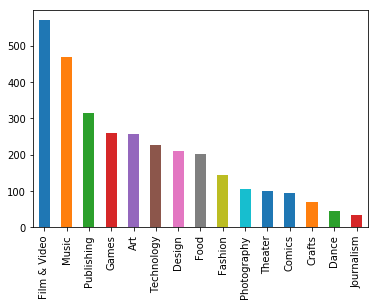

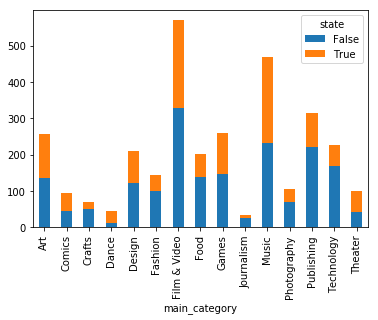

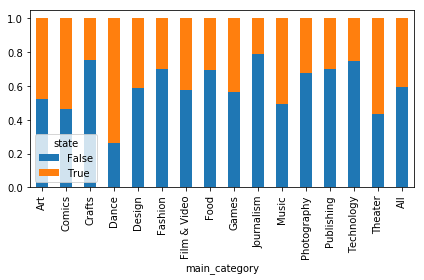

In [50]:
# main_categoryをクロス集計表で確認
df3['main_category'].value_counts().plot(kind="bar")
pd.crosstab(df3['main_category'], df3['state']).plot(kind="bar", stacked=True)
pd.crosstab(df3['main_category'], df3['state'], margins=True, normalize='index').plot(kind="bar", stacked=True)
plt.tight_layout()
plt.show()
# 使えそう

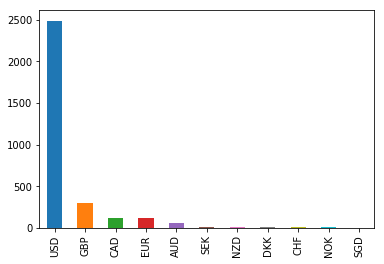

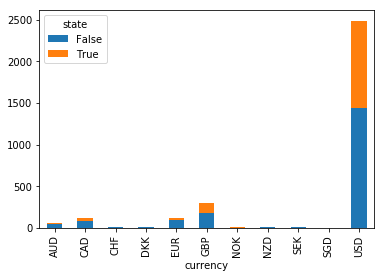

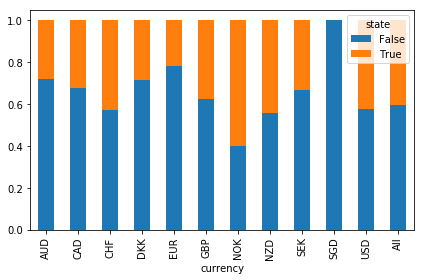

In [51]:
# currencyをクロス集計表で確認
df3['currency'].value_counts().plot(kind="bar")
pd.crosstab(df3['currency'], df3['state']).plot(kind="bar", stacked=True)
pd.crosstab(df3['currency'], df3['state'], margins=True, normalize='index').plot(kind="bar", stacked=True)
plt.tight_layout()
plt.show()
# 使えそう